In [1]:
from mpl_toolkits import mplot3d
%matplotlib inline
import json
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats
from itertools import chain
from scipy import stats
from IPython.display import display
import pandas as pd
import pickle
from itertools import chain
import matplotlib.pylab as pylab

In [2]:
p_threshold = 0.05
metrics = ['acc', 'f1', 'roc']
all_subjects = [ "S" + str(i) for i in range(2, 18) if i != 12]
testing_range = [x/100 for x in np.arange(1, 5, 0.1)] + [x/100 for x in np.arange(5, 95,1)] + [x/100 for x in np.arange(95,99.7,0.1)]

# Subject Dependent Model

In [3]:
k = 5
runs = 5

In [4]:
all_best_no_updates = []
all_best_updates = []
all_fully_supervised = []

table_data = {
    met: {} for met in metrics
}
   
im_std_supervised = []
im_std_semisupervised = []
    
for metric in metrics:
    
    for points in testing_range:
        start_labeled_data_points = str(points)

        all_data = {
            sub: [] for sub in all_subjects
        }

        for sub in all_subjects:
            with open('TestingResults/WESAD/IM/runs_{0}_k_{1}_subject_{2}.json'.format(runs, k, sub), 'r') as fp:
                all_data[sub] = json.load(fp)['2'][sub]

        length_of_updates_increments = np.min([len(all_data[sub][start_labeled_data_points][str(run)]['data_points']) for run in range(runs) for sub in all_subjects])

        updates_arr = {
            range_ints: [] for range_ints in range(length_of_updates_increments)
        }
        updates_arr_max = {
            range_ints: [] for range_ints in range(length_of_updates_increments)
        }
        updates_arr_min = {
            range_ints: [] for range_ints in range(length_of_updates_increments)
        }

        random_arr = {
            range_ints: [] for range_ints in range(length_of_updates_increments)
        }
        random_arr_max = {
            range_ints: [] for range_ints in range(length_of_updates_increments)
        }
        random_arr_min = {
            range_ints: [] for range_ints in range(length_of_updates_increments)
        }
        no_updates_arr = []

        for sub in all_subjects:
            no_updates_arr.append(np.mean([all_data[sub][start_labeled_data_points][str(run)][metric]['Supervised_partial'] for run in range(runs) ]))
            for range_ints in range(length_of_updates_increments): 
                all_runs_updates = [all_data[sub][start_labeled_data_points][str(run)][metric]['Supervised_updates'] for run in range(runs) ]
                all_runs_random = [all_data[sub][start_labeled_data_points][str(run)][metric]['Supervised_repeat'] for run in range(runs) ]
                
                all_fully_supervised.extend([all_data[sub][start_labeled_data_points][str(run)][metric]['Supervised_full'] for run in range(runs) ])
                
                updates_arr[range_ints].append(np.mean([ x[range_ints] for x in all_runs_updates]))
                updates_arr_max[range_ints].append(np.max([ x[range_ints] for x in all_runs_updates]))
                updates_arr_min[range_ints].append(np.min([ x[range_ints] for x in all_runs_updates]))

                random_arr[range_ints].append(np.mean([ x[range_ints] for x in all_runs_random]))
                random_arr_max[range_ints].append(np.max([ x[range_ints] for x in all_runs_random]))
                random_arr_min[range_ints].append(np.min([ x[range_ints] for x in all_runs_random]))

        no_updates_acc = np.mean(no_updates_arr)
        no_updates_std = np.std(no_updates_arr)

        all_runs_best_no_updates = list(np.mean([random_arr[x] for x in random_arr.keys()], axis=0))
        best_vals = [np.mean([np.max(all_data[sub][start_labeled_data_points][str(run)][metric]['Supervised_updates']) for run in range(runs)]) for sub in all_subjects]
        
        if metric == 'acc':
            values = [all_data[sub][start_labeled_data_points][str(run)]["acc"]['Supervised_updates'] for sub in all_subjects for run in range(runs)]
            im_std_semisupervised.append(np.std(list(chain.from_iterable(values))))
            values = [all_data[sub][start_labeled_data_points][str(run)]["acc"]['Supervised_repeat'] for sub in all_subjects for run in range(runs)]
            im_std_supervised.append(np.std(list(chain.from_iterable(values))))
        res = stats.ttest_rel(all_runs_best_no_updates, best_vals)

        if res[1] < p_threshold:
            different = 'Different'
        else:
            different = 'Not Different'

        table_data[metric].update({
            "{:.2f}% of data".format(float(start_labeled_data_points) * 100): {
                'Mean SL': np.mean(all_runs_best_no_updates) * 100, 
                'Mean SSL': np.mean(best_vals) * 100,
                'Difference': (np.mean(best_vals) * 100) - (np.mean(all_runs_best_no_updates) * 100),
                't_val': res[0], 
                'p_val': res[1],
                'Result': different
            }
        })

In [5]:
def color_negative_black(val):
    color = 'green' if val == 'Different' else 'black'
    return 'background-color: %s' % color

In [6]:
dfs = {}
for metric in metrics:
    df = pd.DataFrame.from_dict(table_data[metric]).T.convert_dtypes()
    
    dfs.update({
        metric: df
    })
    d = df.style.background_gradient(cmap ='coolwarm').applymap(color_negative_black, subset=["Result"]).set_caption("Data for Metric: {0}".format(metric))
    display(d)
    
    print(df.to_latex())

,Mean SL,Mean SSL,Difference,t_val,p_val,Result
1.00% of data,83.286147,90.452132,7.165985,-4.693689,0.000345,Different
1.10% of data,82.312766,91.057710,8.744944,-5.490305,0.000080,Different
1.20% of data,83.639295,90.469576,6.830281,-5.555985,0.000071,Different
1.30% of data,83.792753,90.343834,6.551081,-5.200104,0.000135,Different
1.40% of data,90.275868,94.705364,4.429496,-5.072609,0.000170,Different
1.50% of data,91.463352,94.501152,3.037800,-3.175655,0.006739,Different
1.60% of data,90.404527,94.003213,3.598686,-3.228711,0.006064,Different
1.70% of data,90.938184,94.643484,3.705300,-3.455331,0.003863,Different
1.80% of data,89.731872,93.062966,3.331093,-3.606984,0.002859,Different
1.90% of data,91.220638,94.142685,2.922047,-2.792113,0.014402,Different


\begin{tabular}{lrrrrrl}
\toprule
{} &    Mean SL &   Mean SSL &  Difference &     t\_val &     p\_val &         Result \\
\midrule
1.00\% of data  &  83.286147 &  90.452132 &    7.165985 & -4.693689 &  0.000345 &      Different \\
1.10\% of data  &  82.312766 &   91.05771 &    8.744944 & -5.490305 &   0.00008 &      Different \\
1.20\% of data  &  83.639295 &  90.469576 &    6.830281 & -5.555985 &  0.000071 &      Different \\
1.30\% of data  &  83.792753 &  90.343834 &    6.551081 & -5.200104 &  0.000135 &      Different \\
1.40\% of data  &  90.275868 &  94.705364 &    4.429496 & -5.072609 &   0.00017 &      Different \\
1.50\% of data  &  91.463352 &  94.501152 &      3.0378 & -3.175655 &  0.006739 &      Different \\
1.60\% of data  &  90.404527 &  94.003213 &    3.598686 & -3.228711 &  0.006064 &      Different \\
1.70\% of data  &  90.938184 &  94.643484 &      3.7053 & -3.455331 &  0.003863 &      Different \\
1.80\% of data  &  89.731872 &  93.062966 &    3.331093 & -3.606984 

,Mean SL,Mean SSL,Difference,t_val,p_val,Result
1.00% of data,83.286147,90.452132,7.165985,-4.693689,0.000345,Different
1.10% of data,82.312766,91.057710,8.744944,-5.490305,0.000080,Different
1.20% of data,83.639295,90.469576,6.830281,-5.555985,0.000071,Different
1.30% of data,83.792753,90.343834,6.551081,-5.200104,0.000135,Different
1.40% of data,90.275868,94.705364,4.429496,-5.072609,0.000170,Different
1.50% of data,91.463352,94.501152,3.037800,-3.175655,0.006739,Different
1.60% of data,90.404527,94.003213,3.598686,-3.228711,0.006064,Different
1.70% of data,90.938184,94.643484,3.705300,-3.455331,0.003863,Different
1.80% of data,89.731872,93.062966,3.331093,-3.606984,0.002859,Different
1.90% of data,91.220638,94.142685,2.922047,-2.792113,0.014402,Different


\begin{tabular}{lrrrrrl}
\toprule
{} &    Mean SL &   Mean SSL &  Difference &     t\_val &     p\_val &         Result \\
\midrule
1.00\% of data  &  83.286147 &  90.452132 &    7.165985 & -4.693689 &  0.000345 &      Different \\
1.10\% of data  &  82.312766 &   91.05771 &    8.744944 & -5.490305 &   0.00008 &      Different \\
1.20\% of data  &  83.639295 &  90.469576 &    6.830281 & -5.555985 &  0.000071 &      Different \\
1.30\% of data  &  83.792753 &  90.343834 &    6.551081 & -5.200104 &  0.000135 &      Different \\
1.40\% of data  &  90.275868 &  94.705364 &    4.429496 & -5.072609 &   0.00017 &      Different \\
1.50\% of data  &  91.463352 &  94.501152 &      3.0378 & -3.175655 &  0.006739 &      Different \\
1.60\% of data  &  90.404527 &  94.003213 &    3.598686 & -3.228711 &  0.006064 &      Different \\
1.70\% of data  &  90.938184 &  94.643484 &      3.7053 & -3.455331 &  0.003863 &      Different \\
1.80\% of data  &  89.731872 &  93.062966 &    3.331093 & -3.606984 

,Mean SL,Mean SSL,Difference,t_val,p_val,Result
1.00% of data,82.861586,90.281241,7.419655,-4.864629,0.000250,Different
1.10% of data,81.837142,91.006237,9.169095,-4.998162,0.000195,Different
1.20% of data,83.320214,90.314986,6.994772,-5.431116,0.000089,Different
1.30% of data,83.415311,90.096365,6.681054,-5.592006,0.000066,Different
1.40% of data,90.094956,94.637329,4.542373,-4.336653,0.000683,Different
1.50% of data,91.412388,94.424140,3.011752,-3.348868,0.004775,Different
1.60% of data,90.295111,93.932732,3.637621,-3.441534,0.003971,Different
1.70% of data,90.756251,94.557743,3.801492,-3.272795,0.005555,Different
1.80% of data,89.485739,92.971707,3.485968,-3.653224,0.002608,Different
1.90% of data,91.284036,94.114964,2.830928,-3.168043,0.006842,Different


,Mean SL,Mean SSL,Difference,t_val,p_val,Result
1.00% of data,82.861586,90.281241,7.419655,-4.864629,0.000250,Different
1.10% of data,81.837142,91.006237,9.169095,-4.998162,0.000195,Different
1.20% of data,83.320214,90.314986,6.994772,-5.431116,0.000089,Different
1.30% of data,83.415311,90.096365,6.681054,-5.592006,0.000066,Different
1.40% of data,90.094956,94.637329,4.542373,-4.336653,0.000683,Different
1.50% of data,91.412388,94.424140,3.011752,-3.348868,0.004775,Different
1.60% of data,90.295111,93.932732,3.637621,-3.441534,0.003971,Different
1.70% of data,90.756251,94.557743,3.801492,-3.272795,0.005555,Different
1.80% of data,89.485739,92.971707,3.485968,-3.653224,0.002608,Different
1.90% of data,91.284036,94.114964,2.830928,-3.168043,0.006842,Different


\begin{tabular}{lrrrrrl}
\toprule
{} &    Mean SL &   Mean SSL &  Difference &     t\_val &     p\_val &         Result \\
\midrule
1.00\% of data  &  82.861586 &  90.281241 &    7.419655 & -4.864629 &   0.00025 &      Different \\
1.10\% of data  &  81.837142 &  91.006237 &    9.169095 & -4.998162 &  0.000195 &      Different \\
1.20\% of data  &  83.320214 &  90.314986 &    6.994772 & -5.431116 &  0.000089 &      Different \\
1.30\% of data  &  83.415311 &  90.096365 &    6.681054 & -5.592006 &  0.000066 &      Different \\
1.40\% of data  &  90.094956 &  94.637329 &    4.542373 & -4.336653 &  0.000683 &      Different \\
1.50\% of data  &  91.412388 &   94.42414 &    3.011752 & -3.348868 &  0.004775 &      Different \\
1.60\% of data  &  90.295111 &  93.932732 &    3.637621 & -3.441534 &  0.003971 &      Different \\
1.70\% of data  &  90.756251 &  94.557743 &    3.801492 & -3.272795 &  0.005555 &      Different \\
1.80\% of data  &  89.485739 &  92.971707 &    3.485968 & -3.653224 

,Mean SL,Mean SSL,Difference,t_val,p_val,Result
1.00% of data,83.286147,90.228405,6.942258,-4.584244,0.000425,Different
1.10% of data,82.312766,90.963395,8.650629,-5.090792,0.000164,Different
1.20% of data,83.639295,90.360933,6.721638,-5.208936,0.000132,Different
1.30% of data,83.792753,89.785944,5.993191,-4.978567,0.000202,Different
1.40% of data,90.275868,94.488275,4.212407,-4.601950,0.000411,Different
1.50% of data,91.463352,94.543279,3.079927,-3.257473,0.005727,Different
1.60% of data,90.404527,93.878645,3.474118,-3.239360,0.005937,Different
1.70% of data,90.938184,94.360130,3.421947,-3.470843,0.003746,Different
1.80% of data,89.731872,93.016378,3.284505,-3.360459,0.004666,Different
1.90% of data,91.220638,93.849365,2.628727,-2.712015,0.016855,Different


\begin{tabular}{lrrrrrl}
\toprule
{} &    Mean SL &   Mean SSL &  Difference &     t\_val &     p\_val &         Result \\
\midrule
1.00\% of data  &  83.286147 &  90.228405 &    6.942258 & -4.584244 &  0.000425 &      Different \\
1.10\% of data  &  82.312766 &  90.963395 &    8.650629 & -5.090792 &  0.000164 &      Different \\
1.20\% of data  &  83.639295 &  90.360933 &    6.721638 & -5.208936 &  0.000132 &      Different \\
1.30\% of data  &  83.792753 &  89.785944 &    5.993191 & -4.978567 &  0.000202 &      Different \\
1.40\% of data  &  90.275868 &  94.488275 &    4.212407 &  -4.60195 &  0.000411 &      Different \\
1.50\% of data  &  91.463352 &  94.543279 &    3.079927 & -3.257473 &  0.005727 &      Different \\
1.60\% of data  &  90.404527 &  93.878645 &    3.474118 &  -3.23936 &  0.005937 &      Different \\
1.70\% of data  &  90.938184 &   94.36013 &    3.421947 & -3.470843 &  0.003746 &      Different \\
1.80\% of data  &  89.731872 &  93.016378 &    3.284505 & -3.360459 

\begin{tabular}{lrrrrrl}
\toprule
{} &    Mean SL &   Mean SSL &  Difference &     t\_val &     p\_val &         Result \\
\midrule
1.00\% of data  &  82.861586 &  90.281241 &    7.419655 & -4.864629 &   0.00025 &      Different \\
1.10\% of data  &  81.837142 &  91.006237 &    9.169095 & -4.998162 &  0.000195 &      Different \\
1.20\% of data  &  83.320214 &  90.314986 &    6.994772 & -5.431116 &  0.000089 &      Different \\
1.30\% of data  &  83.415311 &  90.096365 &    6.681054 & -5.592006 &  0.000066 &      Different \\
1.40\% of data  &  90.094956 &  94.637329 &    4.542373 & -4.336653 &  0.000683 &      Different \\
1.50\% of data  &  91.412388 &   94.42414 &    3.011752 & -3.348868 &  0.004775 &      Different \\
1.60\% of data  &  90.295111 &  93.932732 &    3.637621 & -3.441534 &  0.003971 &      Different \\
1.70\% of data  &  90.756251 &  94.557743 &    3.801492 & -3.272795 &  0.005555 &      Different \\
1.80\% of data  &  89.485739 &  92.971707 &    3.485968 & -3.653224 

,Mean SL,Mean SSL,Difference,t_val,p_val,Result
1.00% of data,83.286147,90.228405,6.942258,-4.584244,0.000425,Different
1.10% of data,82.312766,90.963395,8.650629,-5.090792,0.000164,Different
1.20% of data,83.639295,90.360933,6.721638,-5.208936,0.000132,Different
1.30% of data,83.792753,89.785944,5.993191,-4.978567,0.000202,Different
1.40% of data,90.275868,94.488275,4.212407,-4.601950,0.000411,Different
1.50% of data,91.463352,94.543279,3.079927,-3.257473,0.005727,Different
1.60% of data,90.404527,93.878645,3.474118,-3.239360,0.005937,Different
1.70% of data,90.938184,94.360130,3.421947,-3.470843,0.003746,Different
1.80% of data,89.731872,93.016378,3.284505,-3.360459,0.004666,Different
1.90% of data,91.220638,93.849365,2.628727,-2.712015,0.016855,Different


\begin{tabular}{lrrrrrl}
\toprule
{} &    Mean SL &   Mean SSL &  Difference &     t\_val &     p\_val &         Result \\
\midrule
1.00\% of data  &  83.286147 &  90.228405 &    6.942258 & -4.584244 &  0.000425 &      Different \\
1.10\% of data  &  82.312766 &  90.963395 &    8.650629 & -5.090792 &  0.000164 &      Different \\
1.20\% of data  &  83.639295 &  90.360933 &    6.721638 & -5.208936 &  0.000132 &      Different \\
1.30\% of data  &  83.792753 &  89.785944 &    5.993191 & -4.978567 &  0.000202 &      Different \\
1.40\% of data  &  90.275868 &  94.488275 &    4.212407 &  -4.60195 &  0.000411 &      Different \\
1.50\% of data  &  91.463352 &  94.543279 &    3.079927 & -3.257473 &  0.005727 &      Different \\
1.60\% of data  &  90.404527 &  93.878645 &    3.474118 &  -3.23936 &  0.005937 &      Different \\
1.70\% of data  &  90.938184 &   94.36013 &    3.421947 & -3.470843 &  0.003746 &      Different \\
1.80\% of data  &  89.731872 &  93.016378 &    3.284505 & -3.360459 

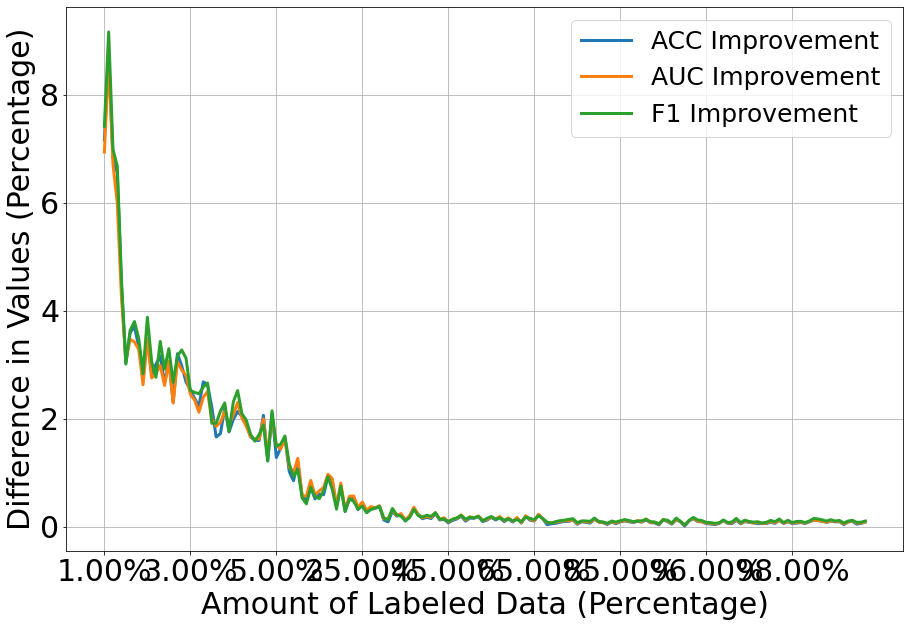

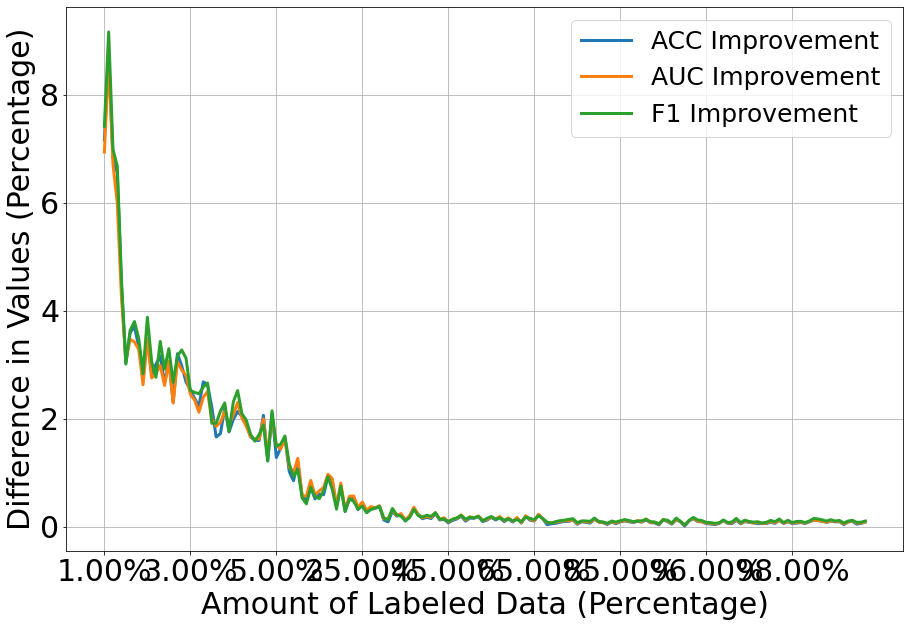

In [7]:
plt.figure(figsize=(15,10))
plt.plot(list(dfs['acc']['Difference']), label='ACC Improvement', linewidth=3)
plt.plot(list(dfs['roc']['Difference']), label='AUC Improvement', linewidth=3)
plt.plot(list(dfs['f1']['Difference']), label='F1 Improvement', linewidth=3)

plt.xticks(range(len([x.split("%")[0] for x in dfs['acc']['Difference'].index])), [x.split("%")[0] + '%' for x in dfs['acc']['Difference'].index])

plt.legend(prop={'size': 25})

plt.xlabel('Amount of Labeled Data (Percentage)', fontsize=30)
plt.ylabel('Difference in Values (Percentage)', fontsize=30)

plt.tick_params(axis='both', which='major', labelsize=30)
plt.tick_params(axis='both', which='minor', labelsize=30)
plt.grid(True)
plt.xticks(plt.xticks()[0][::20])

# plt.savefig('acc_roc_f1_group.png', dpi=500)
plt.show()

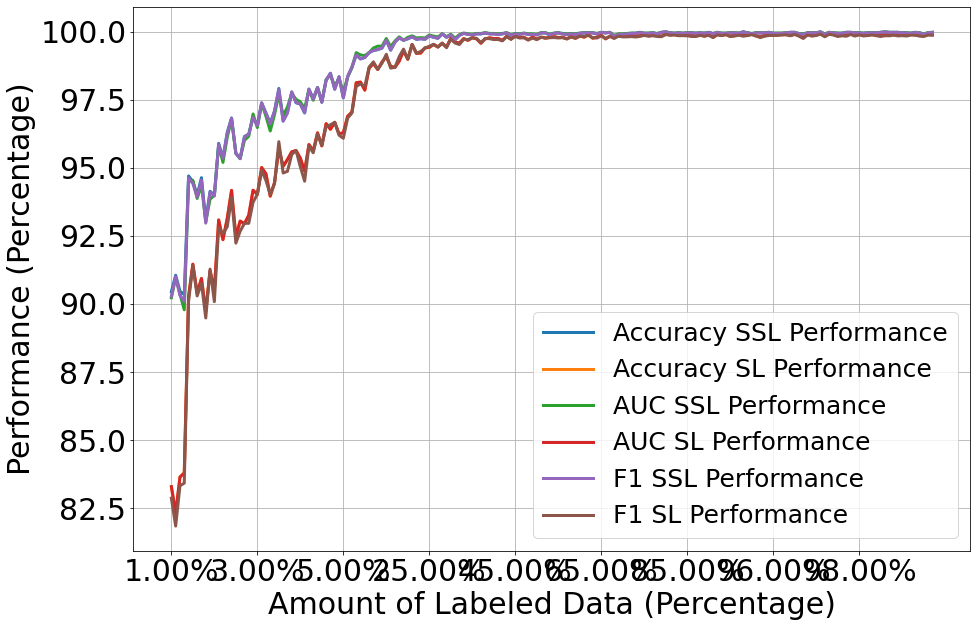

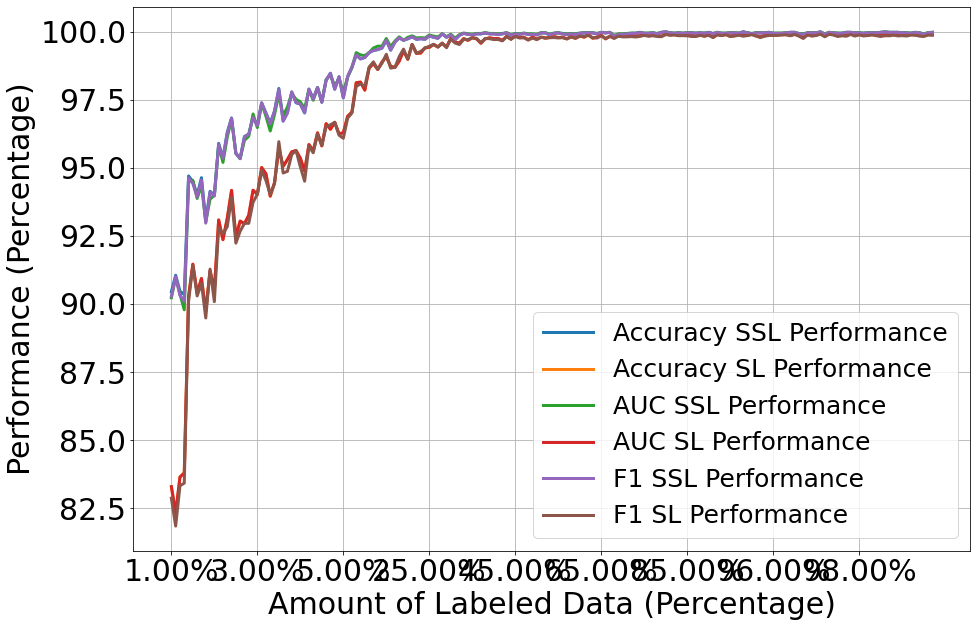

In [8]:
plt.figure(figsize=(15,10))
plt.plot(list(dfs['acc']['Mean SSL']), label='Accuracy SSL Performance', linewidth=3)
plt.plot(list(dfs['acc']['Mean SL']), label='Accuracy SL Performance', linewidth=3)

plt.plot(list(dfs['roc']['Mean SSL']), label='AUC SSL Performance', linewidth=3)
plt.plot(list(dfs['roc']['Mean SL']), label='AUC SL Performance', linewidth=3)

plt.plot(list(dfs['f1']['Mean SSL']), label='F1 SSL Performance', linewidth=3)
plt.plot(list(dfs['f1']['Mean SL']), label='F1 SL Performance', linewidth=3)

plt.xticks(range(0, len([x.split("%")[0] for x in dfs['acc'].index])), [x.split("%")[0] + '%' for x in dfs['acc'].index])
plt.legend(prop={'size': 25})

plt.xlabel('Amount of Labeled Data (Percentage)', fontsize=30)
plt.ylabel('Performance (Percentage)', fontsize=30)

plt.tick_params(axis='both', which='major', labelsize=30)
plt.tick_params(axis='both', which='minor', labelsize=30)

plt.grid(True)
plt.xticks(plt.xticks()[0][::20])

# plt.savefig('im_f1_ssl.png', dpi=500)
plt.show()

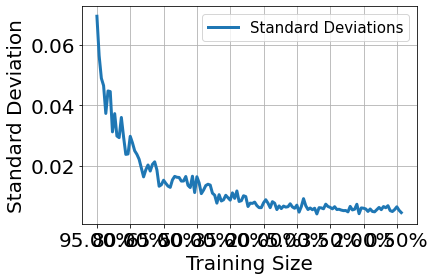

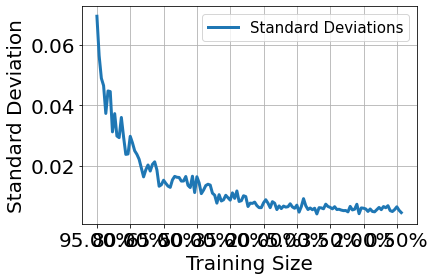

In [9]:
xi = list(range(len(testing_range[40:])))
plt.plot(xi, im_std_semisupervised[40:], label='Standard Deviations', linewidth=3)
plt.legend(prop={'size': 15})

plt.xlabel('Training Size', fontsize=20)
plt.ylabel('Standard Deviation', fontsize=20)

plt.tick_params(axis='both', which='major', labelsize=20)
plt.tick_params(axis='both', which='minor', labelsize=20)
plt.grid(True)
plt.xticks(xi, ['{:.2f}%'.format((1 - x) * 100) for x in testing_range[40:]])
plt.xticks(plt.xticks()[0][::15])

# plt.savefig('im_std_ssl.png', dpi=500, bbox_inches='tight')
plt.show()

# Subject Independent Model

In [10]:
k = 100
runs = 5

In [11]:
all_best_no_updates = []
all_best_updates = []
all_fully_supervised = []

table_data = {
    met: {} for met in metrics
}
   
gm_std_supervised = []
gm_std_semisupervised = []
    
for metric in metrics:
    
    for points in testing_range:
        start_labeled_data_points = str(points)

        all_data = {
            sub: [] for sub in all_subjects
        }

        for sub in all_subjects:
            with open('TestingResults/WESAD/GM/runs_{0}_k_{1}_subject_{2}.json'.format(runs, k, sub), 'r') as fp:
                all_data[sub] = json.load(fp)['2'][sub]

        length_of_updates_increments = np.min([len(all_data[sub][start_labeled_data_points][str(run)]['data_points']) for run in range(runs) for sub in all_subjects])

        updates_arr = {
            range_ints: [] for range_ints in range(length_of_updates_increments)
        }
        updates_arr_max = {
            range_ints: [] for range_ints in range(length_of_updates_increments)
        }
        updates_arr_min = {
            range_ints: [] for range_ints in range(length_of_updates_increments)
        }

        random_arr = {
            range_ints: [] for range_ints in range(length_of_updates_increments)
        }
        random_arr_max = {
            range_ints: [] for range_ints in range(length_of_updates_increments)
        }
        random_arr_min = {
            range_ints: [] for range_ints in range(length_of_updates_increments)
        }
        no_updates_arr = []

        for sub in all_subjects:
            no_updates_arr.append(np.mean([all_data[sub][start_labeled_data_points][str(run)][metric]['Supervised_partial'] for run in range(runs) ]))
            for range_ints in range(length_of_updates_increments): 
                all_runs_updates = [all_data[sub][start_labeled_data_points][str(run)][metric]['Supervised_updates'] for run in range(runs) ]
                all_runs_random = [all_data[sub][start_labeled_data_points][str(run)][metric]['Supervised_repeat'] for run in range(runs) ]
                
                all_fully_supervised.extend([all_data[sub][start_labeled_data_points][str(run)][metric]['Supervised_full'] for run in range(runs) ])
                
                updates_arr[range_ints].append(np.mean([ x[range_ints] for x in all_runs_updates]))
                updates_arr_max[range_ints].append(np.max([ x[range_ints] for x in all_runs_updates]))
                updates_arr_min[range_ints].append(np.min([ x[range_ints] for x in all_runs_updates]))

                random_arr[range_ints].append(np.mean([ x[range_ints] for x in all_runs_random]))
                random_arr_max[range_ints].append(np.max([ x[range_ints] for x in all_runs_random]))
                random_arr_min[range_ints].append(np.min([ x[range_ints] for x in all_runs_random]))

        no_updates_acc = np.mean(no_updates_arr)
        no_updates_std = np.std(no_updates_arr)

        all_runs_best_no_updates = list(np.mean([random_arr[x] for x in random_arr.keys()], axis=0))
        best_vals = [np.mean([np.max(all_data[sub][start_labeled_data_points][str(run)][metric]['Supervised_updates']) for run in range(runs)]) for sub in all_subjects]
        
        if metric == 'acc':
            values = [all_data[sub][start_labeled_data_points][str(run)]["acc"]['Supervised_updates'] for sub in all_subjects for run in range(runs)]
            gm_std_semisupervised.append(np.std(list(chain.from_iterable(values))))
            values = [all_data[sub][start_labeled_data_points][str(run)]["acc"]['Supervised_repeat'] for sub in all_subjects for run in range(runs)]
            gm_std_supervised.append(np.std(list(chain.from_iterable(values))))
        res = stats.ttest_rel(all_runs_best_no_updates, best_vals)

        if res[1] < p_threshold:
            different = 'Different'
        else:
            different = 'Not Different'

        table_data[metric].update({
            "{:.2f}% of data".format(float(start_labeled_data_points) * 100): {
                'Mean SL': np.mean(all_runs_best_no_updates) * 100, 
                'Mean SSL': np.mean(best_vals) * 100,
                'Difference': (np.mean(best_vals) * 100) - (np.mean(all_runs_best_no_updates) * 100),
                't_val': res[0], 
                'p_val': res[1],
                'Result': different
            }
        })

In [12]:
def color_negative_black(val):
    color = 'green' if val == 'Different' else 'black'
    return 'background-color: %s' % color

In [13]:
dfs = {}
for metric in metrics:
    df = pd.DataFrame.from_dict(table_data[metric]).T.convert_dtypes()
    
    dfs.update({
        metric: df
    })
    d = df.style.background_gradient(cmap ='coolwarm').applymap(color_negative_black, subset=["Result"]).set_caption("Data for Metric: {0}".format(metric))
    display(d)
    
    print(df.to_latex())

,Mean SL,Mean SSL,Difference,t_val,p_val,Result
1.00% of data,80.753325,86.778884,6.025559,-3.746071,0.002170,Different
1.10% of data,80.472472,86.340257,5.867784,-3.585955,0.002980,Different
1.20% of data,81.458659,86.304845,4.846187,-3.299634,0.005266,Different
1.30% of data,80.167055,86.854725,6.687670,-3.528649,0.003340,Different
1.40% of data,80.940228,86.585279,5.645051,-4.098365,0.001086,Different
1.50% of data,81.755329,85.797482,4.042153,-2.886520,0.011956,Different
1.60% of data,81.892337,86.189597,4.297259,-3.585037,0.002986,Different
1.70% of data,80.081406,85.585446,5.504040,-3.017704,0.009222,Different
1.80% of data,81.089281,86.034591,4.945310,-3.048915,0.008668,Different
1.90% of data,80.393447,86.319539,5.926091,-2.645999,0.019178,Different


,Mean SL,Mean SSL,Difference,t_val,p_val,Result
1.00% of data,80.753325,86.778884,6.025559,-3.746071,0.002170,Different
1.10% of data,80.472472,86.340257,5.867784,-3.585955,0.002980,Different
1.20% of data,81.458659,86.304845,4.846187,-3.299634,0.005266,Different
1.30% of data,80.167055,86.854725,6.687670,-3.528649,0.003340,Different
1.40% of data,80.940228,86.585279,5.645051,-4.098365,0.001086,Different
1.50% of data,81.755329,85.797482,4.042153,-2.886520,0.011956,Different
1.60% of data,81.892337,86.189597,4.297259,-3.585037,0.002986,Different
1.70% of data,80.081406,85.585446,5.504040,-3.017704,0.009222,Different
1.80% of data,81.089281,86.034591,4.945310,-3.048915,0.008668,Different
1.90% of data,80.393447,86.319539,5.926091,-2.645999,0.019178,Different


\begin{tabular}{lrrrrrl}
\toprule
{} &    Mean SL &   Mean SSL &  Difference &     t\_val &     p\_val &     Result \\
\midrule
1.00\% of data  &  80.753325 &  86.778884 &    6.025559 & -3.746071 &   0.00217 &  Different \\
1.10\% of data  &  80.472472 &  86.340257 &    5.867784 & -3.585955 &   0.00298 &  Different \\
1.20\% of data  &  81.458659 &  86.304845 &    4.846187 & -3.299634 &  0.005266 &  Different \\
1.30\% of data  &  80.167055 &  86.854725 &     6.68767 & -3.528649 &   0.00334 &  Different \\
1.40\% of data  &  80.940228 &  86.585279 &    5.645051 & -4.098365 &  0.001086 &  Different \\
1.50\% of data  &  81.755329 &  85.797482 &    4.042153 &  -2.88652 &  0.011956 &  Different \\
1.60\% of data  &  81.892337 &  86.189597 &    4.297259 & -3.585037 &  0.002986 &  Different \\
1.70\% of data  &  80.081406 &  85.585446 &     5.50404 & -3.017704 &  0.009222 &  Different \\
1.80\% of data  &  81.089281 &  86.034591 &     4.94531 & -3.048915 &  0.008668 &  Different \\
1.90\% o

\begin{tabular}{lrrrrrl}
\toprule
{} &    Mean SL &   Mean SSL &  Difference &     t\_val &     p\_val &     Result \\
\midrule
1.00\% of data  &  80.753325 &  86.778884 &    6.025559 & -3.746071 &   0.00217 &  Different \\
1.10\% of data  &  80.472472 &  86.340257 &    5.867784 & -3.585955 &   0.00298 &  Different \\
1.20\% of data  &  81.458659 &  86.304845 &    4.846187 & -3.299634 &  0.005266 &  Different \\
1.30\% of data  &  80.167055 &  86.854725 &     6.68767 & -3.528649 &   0.00334 &  Different \\
1.40\% of data  &  80.940228 &  86.585279 &    5.645051 & -4.098365 &  0.001086 &  Different \\
1.50\% of data  &  81.755329 &  85.797482 &    4.042153 &  -2.88652 &  0.011956 &  Different \\
1.60\% of data  &  81.892337 &  86.189597 &    4.297259 & -3.585037 &  0.002986 &  Different \\
1.70\% of data  &  80.081406 &  85.585446 &     5.50404 & -3.017704 &  0.009222 &  Different \\
1.80\% of data  &  81.089281 &  86.034591 &     4.94531 & -3.048915 &  0.008668 &  Different \\
1.90\% o

,Mean SL,Mean SSL,Difference,t_val,p_val,Result
1.00% of data,80.324540,86.665059,6.340519,-4.026782,0.001249,Different
1.10% of data,79.629014,86.258188,6.629174,-4.124464,0.001032,Different
1.20% of data,80.622780,86.191214,5.568434,-4.167410,0.000949,Different
1.30% of data,79.548708,86.742410,7.193702,-3.756953,0.002124,Different
1.40% of data,80.176831,86.512507,6.335675,-4.813517,0.000275,Different
1.50% of data,81.199118,85.708411,4.509293,-3.550810,0.003196,Different
1.60% of data,81.108320,86.145034,5.036714,-5.748176,0.000050,Different
1.70% of data,78.556376,85.472671,6.916295,-3.215263,0.006229,Different
1.80% of data,80.518284,85.861161,5.342878,-3.839029,0.001806,Different
1.90% of data,79.174690,86.271702,7.097012,-2.891335,0.011843,Different


,Mean SL,Mean SSL,Difference,t_val,p_val,Result
1.00% of data,80.324540,86.665059,6.340519,-4.026782,0.001249,Different
1.10% of data,79.629014,86.258188,6.629174,-4.124464,0.001032,Different
1.20% of data,80.622780,86.191214,5.568434,-4.167410,0.000949,Different
1.30% of data,79.548708,86.742410,7.193702,-3.756953,0.002124,Different
1.40% of data,80.176831,86.512507,6.335675,-4.813517,0.000275,Different
1.50% of data,81.199118,85.708411,4.509293,-3.550810,0.003196,Different
1.60% of data,81.108320,86.145034,5.036714,-5.748176,0.000050,Different
1.70% of data,78.556376,85.472671,6.916295,-3.215263,0.006229,Different
1.80% of data,80.518284,85.861161,5.342878,-3.839029,0.001806,Different
1.90% of data,79.174690,86.271702,7.097012,-2.891335,0.011843,Different


\begin{tabular}{lrrrrrl}
\toprule
{} &    Mean SL &   Mean SSL &  Difference &     t\_val &     p\_val &     Result \\
\midrule
1.00\% of data  &   80.32454 &  86.665059 &    6.340519 & -4.026782 &  0.001249 &  Different \\
1.10\% of data  &  79.629014 &  86.258188 &    6.629174 & -4.124464 &  0.001032 &  Different \\
1.20\% of data  &   80.62278 &  86.191214 &    5.568434 &  -4.16741 &  0.000949 &  Different \\
1.30\% of data  &  79.548708 &   86.74241 &    7.193702 & -3.756953 &  0.002124 &  Different \\
1.40\% of data  &  80.176831 &  86.512507 &    6.335675 & -4.813517 &  0.000275 &  Different \\
1.50\% of data  &  81.199118 &  85.708411 &    4.509293 &  -3.55081 &  0.003196 &  Different \\
1.60\% of data  &   81.10832 &  86.145034 &    5.036714 & -5.748176 &   0.00005 &  Different \\
1.70\% of data  &  78.556376 &  85.472671 &    6.916295 & -3.215263 &  0.006229 &  Different \\
1.80\% of data  &  80.518284 &  85.861161 &    5.342878 & -3.839029 &  0.001806 &  Different \\
1.90\% o

\begin{tabular}{lrrrrrl}
\toprule
{} &    Mean SL &   Mean SSL &  Difference &     t\_val &     p\_val &     Result \\
\midrule
1.00\% of data  &   80.32454 &  86.665059 &    6.340519 & -4.026782 &  0.001249 &  Different \\
1.10\% of data  &  79.629014 &  86.258188 &    6.629174 & -4.124464 &  0.001032 &  Different \\
1.20\% of data  &   80.62278 &  86.191214 &    5.568434 &  -4.16741 &  0.000949 &  Different \\
1.30\% of data  &  79.548708 &   86.74241 &    7.193702 & -3.756953 &  0.002124 &  Different \\
1.40\% of data  &  80.176831 &  86.512507 &    6.335675 & -4.813517 &  0.000275 &  Different \\
1.50\% of data  &  81.199118 &  85.708411 &    4.509293 &  -3.55081 &  0.003196 &  Different \\
1.60\% of data  &   81.10832 &  86.145034 &    5.036714 & -5.748176 &   0.00005 &  Different \\
1.70\% of data  &  78.556376 &  85.472671 &    6.916295 & -3.215263 &  0.006229 &  Different \\
1.80\% of data  &  80.518284 &  85.861161 &    5.342878 & -3.839029 &  0.001806 &  Different \\
1.90\% o

,Mean SL,Mean SSL,Difference,t_val,p_val,Result
1.00% of data,80.753325,86.806231,6.052906,-4.798612,0.000283,Different
1.10% of data,80.472472,86.253866,5.781393,-4.339126,0.000680,Different
1.20% of data,81.458659,86.338875,4.880216,-4.316933,0.000710,Different
1.30% of data,80.167055,86.794003,6.626948,-3.998091,0.001321,Different
1.40% of data,80.940228,86.595429,5.655201,-5.364357,0.000100,Different
1.50% of data,81.755329,86.028763,4.273434,-4.076773,0.001132,Different
1.60% of data,81.892337,86.321631,4.429294,-5.528843,0.000074,Different
1.70% of data,80.081406,85.722084,5.640678,-3.578220,0.003027,Different
1.80% of data,81.089281,85.882459,4.793178,-4.152084,0.000978,Different
1.90% of data,80.393447,86.543560,6.150113,-3.210490,0.006288,Different


,Mean SL,Mean SSL,Difference,t_val,p_val,Result
1.00% of data,80.753325,86.806231,6.052906,-4.798612,0.000283,Different
1.10% of data,80.472472,86.253866,5.781393,-4.339126,0.000680,Different
1.20% of data,81.458659,86.338875,4.880216,-4.316933,0.000710,Different
1.30% of data,80.167055,86.794003,6.626948,-3.998091,0.001321,Different
1.40% of data,80.940228,86.595429,5.655201,-5.364357,0.000100,Different
1.50% of data,81.755329,86.028763,4.273434,-4.076773,0.001132,Different
1.60% of data,81.892337,86.321631,4.429294,-5.528843,0.000074,Different
1.70% of data,80.081406,85.722084,5.640678,-3.578220,0.003027,Different
1.80% of data,81.089281,85.882459,4.793178,-4.152084,0.000978,Different
1.90% of data,80.393447,86.543560,6.150113,-3.210490,0.006288,Different


\begin{tabular}{lrrrrrl}
\toprule
{} &    Mean SL &   Mean SSL &  Difference &     t\_val &     p\_val &     Result \\
\midrule
1.00\% of data  &  80.753325 &  86.806231 &    6.052906 & -4.798612 &  0.000283 &  Different \\
1.10\% of data  &  80.472472 &  86.253866 &    5.781393 & -4.339126 &   0.00068 &  Different \\
1.20\% of data  &  81.458659 &  86.338875 &    4.880216 & -4.316933 &   0.00071 &  Different \\
1.30\% of data  &  80.167055 &  86.794003 &    6.626948 & -3.998091 &  0.001321 &  Different \\
1.40\% of data  &  80.940228 &  86.595429 &    5.655201 & -5.364357 &    0.0001 &  Different \\
1.50\% of data  &  81.755329 &  86.028763 &    4.273434 & -4.076773 &  0.001132 &  Different \\
1.60\% of data  &  81.892337 &  86.321631 &    4.429294 & -5.528843 &  0.000074 &  Different \\
1.70\% of data  &  80.081406 &  85.722084 &    5.640678 &  -3.57822 &  0.003027 &  Different \\
1.80\% of data  &  81.089281 &  85.882459 &    4.793178 & -4.152084 &  0.000978 &  Different \\
1.90\% o

\begin{tabular}{lrrrrrl}
\toprule
{} &    Mean SL &   Mean SSL &  Difference &     t\_val &     p\_val &     Result \\
\midrule
1.00\% of data  &  80.753325 &  86.806231 &    6.052906 & -4.798612 &  0.000283 &  Different \\
1.10\% of data  &  80.472472 &  86.253866 &    5.781393 & -4.339126 &   0.00068 &  Different \\
1.20\% of data  &  81.458659 &  86.338875 &    4.880216 & -4.316933 &   0.00071 &  Different \\
1.30\% of data  &  80.167055 &  86.794003 &    6.626948 & -3.998091 &  0.001321 &  Different \\
1.40\% of data  &  80.940228 &  86.595429 &    5.655201 & -5.364357 &    0.0001 &  Different \\
1.50\% of data  &  81.755329 &  86.028763 &    4.273434 & -4.076773 &  0.001132 &  Different \\
1.60\% of data  &  81.892337 &  86.321631 &    4.429294 & -5.528843 &  0.000074 &  Different \\
1.70\% of data  &  80.081406 &  85.722084 &    5.640678 &  -3.57822 &  0.003027 &  Different \\
1.80\% of data  &  81.089281 &  85.882459 &    4.793178 & -4.152084 &  0.000978 &  Different \\
1.90\% o

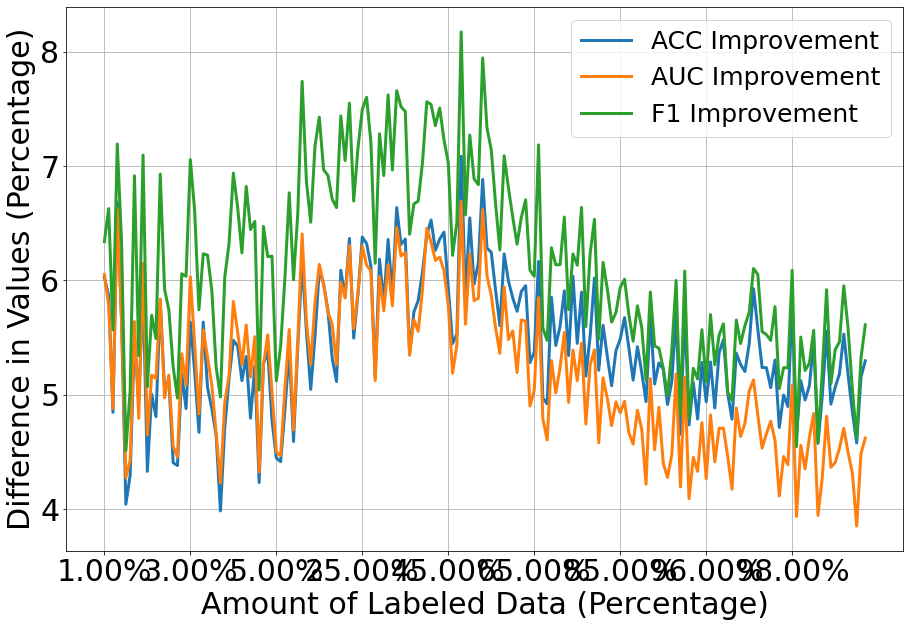

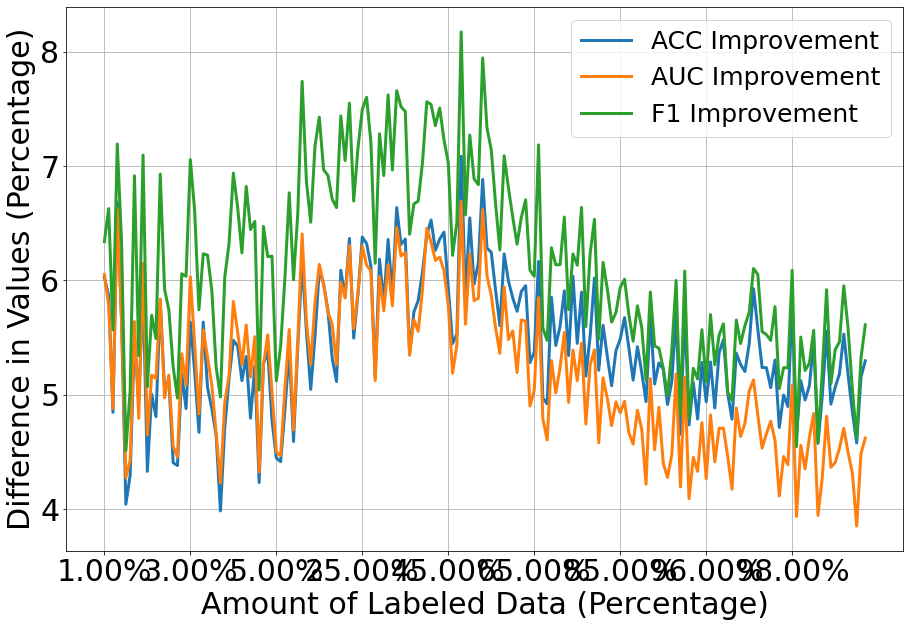

In [14]:
plt.figure(figsize=(15,10))
plt.plot(list(dfs['acc']['Difference']), label='ACC Improvement', linewidth=3)
plt.plot(list(dfs['roc']['Difference']), label='AUC Improvement', linewidth=3)
plt.plot(list(dfs['f1']['Difference']), label='F1 Improvement', linewidth=3)

plt.xticks(range(len([x.split("%")[0] for x in dfs['acc']['Difference'].index])), [x.split("%")[0] + '%' for x in dfs['acc']['Difference'].index])

plt.legend(prop={'size': 25})

plt.xlabel('Amount of Labeled Data (Percentage)', fontsize=30)
plt.ylabel('Difference in Values (Percentage)', fontsize=30)

plt.tick_params(axis='both', which='major', labelsize=30)
plt.tick_params(axis='both', which='minor', labelsize=30)
plt.grid(True)
plt.xticks(plt.xticks()[0][::20])

# plt.savefig('acc_roc_f1_group.png', dpi=500)
plt.show()

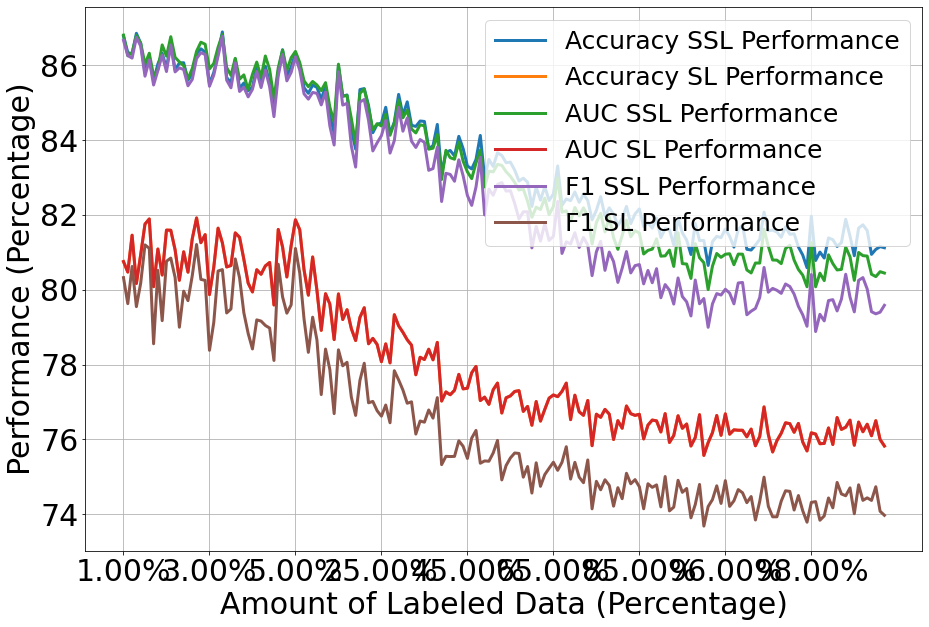

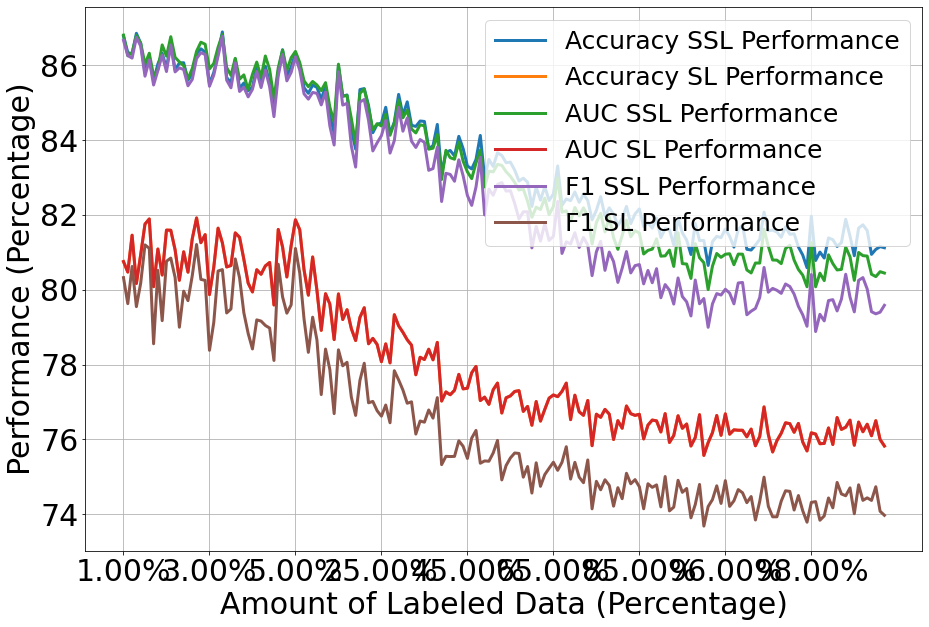

In [15]:
plt.figure(figsize=(15,10))
plt.plot(list(dfs['acc']['Mean SSL']), label='Accuracy SSL Performance', linewidth=3)
plt.plot(list(dfs['acc']['Mean SL']), label='Accuracy SL Performance', linewidth=3)

plt.plot(list(dfs['roc']['Mean SSL']), label='AUC SSL Performance', linewidth=3)
plt.plot(list(dfs['roc']['Mean SL']), label='AUC SL Performance', linewidth=3)

plt.plot(list(dfs['f1']['Mean SSL']), label='F1 SSL Performance', linewidth=3)
plt.plot(list(dfs['f1']['Mean SL']), label='F1 SL Performance', linewidth=3)

plt.xticks(range(0, len([x.split("%")[0] for x in dfs['acc'].index])), [x.split("%")[0] + '%' for x in dfs['acc'].index])
plt.legend(prop={'size': 25})

plt.xlabel('Amount of Labeled Data (Percentage)', fontsize=30)
plt.ylabel('Performance (Percentage)', fontsize=30)

plt.tick_params(axis='both', which='major', labelsize=30)
plt.tick_params(axis='both', which='minor', labelsize=30)

plt.grid(True)
plt.xticks(plt.xticks()[0][::20])

# plt.savefig('gm_f1_ssl.png', dpi=500)
plt.show()

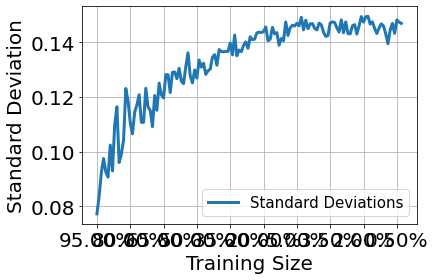

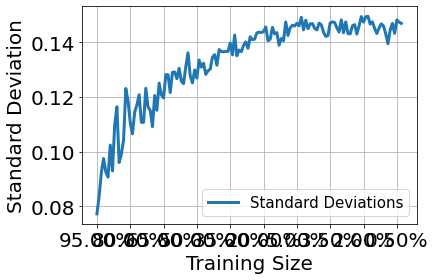

In [16]:
xi = list(range(len(testing_range[40:])))
plt.plot(xi, gm_std_semisupervised[40:], label='Standard Deviations', linewidth=3)
plt.legend(prop={'size': 15})

plt.xlabel('Training Size', fontsize=20)
plt.ylabel('Standard Deviation', fontsize=20)

plt.tick_params(axis='both', which='major', labelsize=20)
plt.tick_params(axis='both', which='minor', labelsize=20)
plt.grid(True)
plt.xticks(xi, ['{:.2f}%'.format((1 - x) * 100) for x in testing_range[40:]])
plt.xticks(plt.xticks()[0][::15])
# plt.savefig('gm_std_ssl.png', dpi=500, bbox_inches='tight')
plt.show()

# Standard Deviation of Subject Dependent Models

In [17]:
loaded_data = {
    points: [] for points in testing_range
}
for test_subject in all_subjects:
    with open('TestingResults/WESAD/IM/Subject_Dependent_{0}.pickle'.format(test_subject), 'rb') as handle:
        data = pickle.load(handle)
    for points in testing_range: loaded_data[points].extend(data[points])

In [18]:
stds = [np.std(loaded_data[key]) for key in loaded_data.keys()]

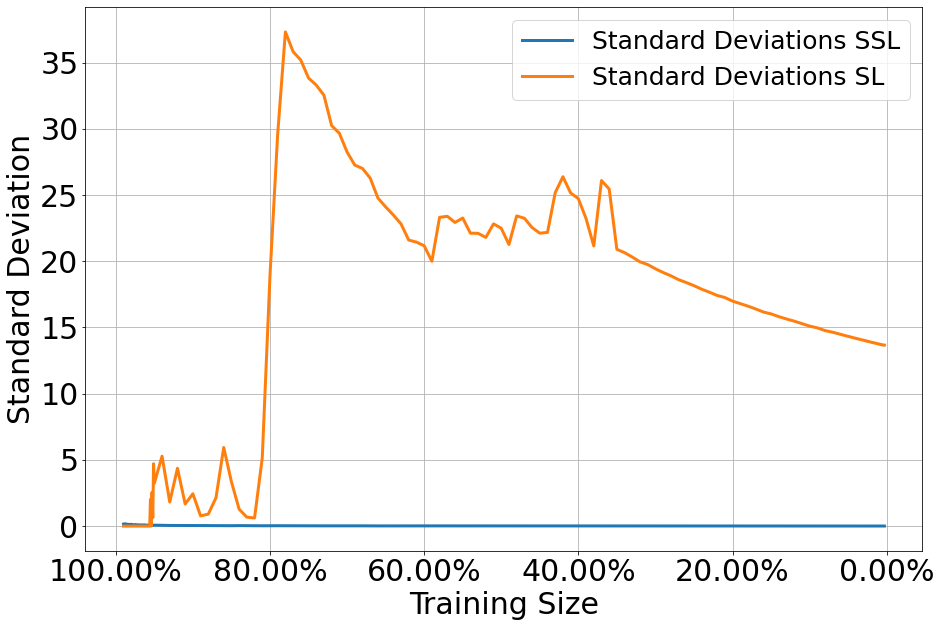

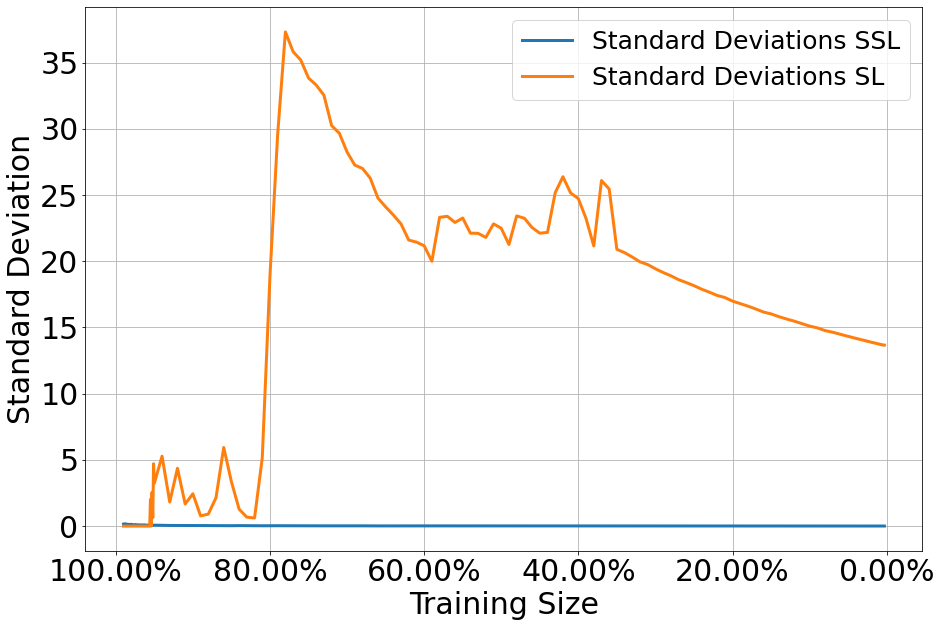

In [19]:
plt.figure(figsize=(15,10))
plt.plot(testing_range, im_std_semisupervised, label='Standard Deviations SSL', linewidth=3)
plt.plot(testing_range, stds, label='Standard Deviations SL', linewidth=3)

plt.legend(prop={'size': 25})

plt.xlabel('Training Size', fontsize=30)
plt.ylabel('Standard Deviation', fontsize=30)

plt.tick_params(axis='both', which='major', labelsize=30)
plt.tick_params(axis='both', which='minor', labelsize=30)
plt.grid(True)
plt.xticks(plt.xticks()[0][1:-1:1])
plt.xticks(plt.xticks()[0], [ '{:.2f}%'.format(abs((1 - x) * 100)) for x in plt.xticks()[0]]) 
plt.savefig('im_std.png', dpi=500)
plt.show()

In [20]:
for x, y, z in zip(testing_range, stds, im_std_semisupervised):
    print("Range {0}, SL {1}, SSL {2}".format(x, y, z))

Range 0.01, SL 0.0, SSL 0.15359816540365073
Range 0.011000000000000001, SL 0.0, SSL 0.1648458306424889
Range 0.012000000000000002, SL 0.0, SSL 0.16958490761639097
Range 0.013000000000000003, SL 0.0, SSL 0.16293567059890487
Range 0.014000000000000004, SL 0.0, SSL 0.1473524097162866
Range 0.015000000000000005, SL 0.0, SSL 0.12882114440181097
Range 0.016000000000000004, SL 0.0, SSL 0.13642288657496585
Range 0.017000000000000005, SL 0.0, SSL 0.11896727083478663
Range 0.018000000000000006, SL 0.0, SSL 0.1262799910161043
Range 0.019000000000000006, SL 0.0, SSL 0.12072267006590695
Range 0.020000000000000007, SL 0.0, SSL 0.13618798080752137
Range 0.021000000000000008, SL 0.0, SSL 0.09411289864495005
Range 0.02200000000000001, SL 0.0, SSL 0.10879328474702782
Range 0.02300000000000001, SL 0.0, SSL 0.10286794559308843
Range 0.02400000000000001, SL 0.0, SSL 0.0918973475847309
Range 0.025000000000000012, SL 0.0, SSL 0.10687012720691555
Range 0.026000000000000013, SL 0.0, SSL 0.12132575278735876
Ran

Range 0.01, SL 0.0, SSL 0.15359816540365073
Range 0.011000000000000001, SL 0.0, SSL 0.1648458306424889
Range 0.012000000000000002, SL 0.0, SSL 0.16958490761639097
Range 0.013000000000000003, SL 0.0, SSL 0.16293567059890487
Range 0.014000000000000004, SL 0.0, SSL 0.1473524097162866
Range 0.015000000000000005, SL 0.0, SSL 0.12882114440181097
Range 0.016000000000000004, SL 0.0, SSL 0.13642288657496585
Range 0.017000000000000005, SL 0.0, SSL 0.11896727083478663
Range 0.018000000000000006, SL 0.0, SSL 0.1262799910161043
Range 0.019000000000000006, SL 0.0, SSL 0.12072267006590695
Range 0.020000000000000007, SL 0.0, SSL 0.13618798080752137
Range 0.021000000000000008, SL 0.0, SSL 0.09411289864495005
Range 0.02200000000000001, SL 0.0, SSL 0.10879328474702782
Range 0.02300000000000001, SL 0.0, SSL 0.10286794559308843
Range 0.02400000000000001, SL 0.0, SSL 0.0918973475847309
Range 0.025000000000000012, SL 0.0, SSL 0.10687012720691555
Range 0.026000000000000013, SL 0.0, SSL 0.12132575278735876
Ran

# Standard Deviation of Subject Independent Models

In [21]:
loaded_data = {
    points: [] for points in testing_range
}
for test_subject in all_subjects:
    with open('TestingResults/WESAD/GM/Subject_Independent_{0}.pickle'.format(test_subject), 'rb') as handle:
        data = pickle.load(handle)
    for points in testing_range: loaded_data[points].extend(data[points])

In [22]:
stds = [np.std(loaded_data[key]) for key in loaded_data.keys()]

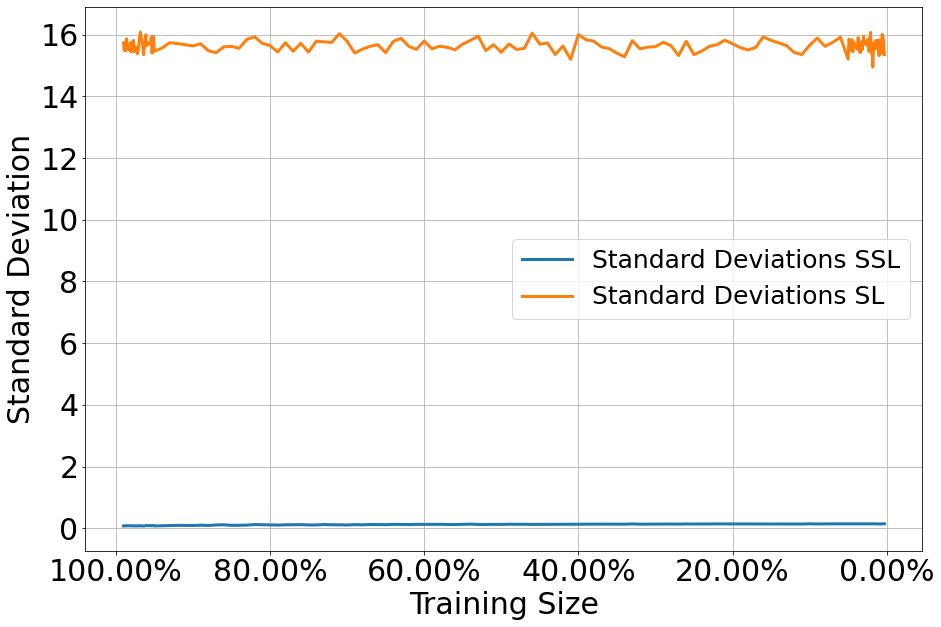

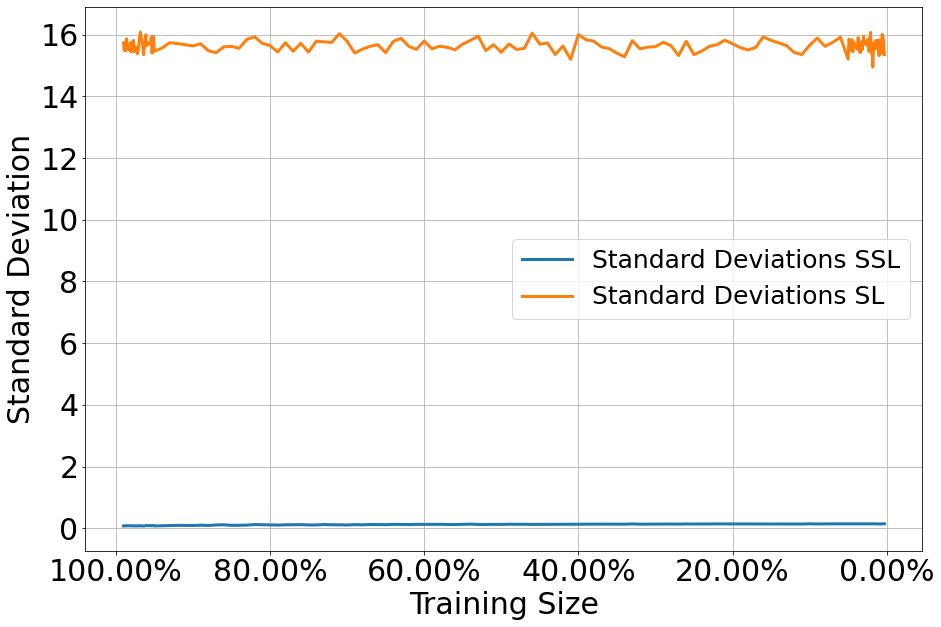

In [23]:
plt.figure(figsize=(15,10))
plt.plot(testing_range, gm_std_semisupervised, label='Standard Deviations SSL', linewidth=3)
plt.plot(testing_range, stds, label='Standard Deviations SL', linewidth=3)

plt.legend(prop={'size': 25})

plt.xlabel('Training Size', fontsize=30)
plt.ylabel('Standard Deviation', fontsize=30)

plt.tick_params(axis='both', which='major', labelsize=30)
plt.tick_params(axis='both', which='minor', labelsize=30)
plt.grid(True)
plt.xticks(plt.xticks()[0][1:-1:1])
plt.xticks(plt.xticks()[0], [ '{:.2f}%'.format(abs((1 - x) * 100)) for x in plt.xticks()[0]]) 
plt.savefig('gm_std.png', dpi=500)
plt.show()